## Contents
<a href='#leading-off'> I. Leading Off - Introduction </a>

<a href='#plot-analysis'> II. Plot Analysis </a>

<a href='#table-analysis'> III. Table Analysis </a>

<a href='#hitting-cleanup'> IV. Hitting Cleanup - Comparative Analysis </a>

## Leading Off
### Introduction
Inspired by the Netflix documentaries and my time in Boston, I've found lineup construction theory to be an incredibly intriguing part of today's game. Sabermetrics have created new high-level ideas that theoretically win baseball games, but the day-to-day managerial decisions are still integral to the success of the baseball team. I look to explore the theoretical side from a data science perspective before examining the player-level ideas in a more journalistic format.

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Dict, Optional

In [112]:
def process_data(filepath: str) -> Optional[pd.DataFrame]:
    """Reads and processes batting split data from a CSV file.

    This function loads data from a specified CSV file, filters for rows 
    containing 'Batting' splits, converts essential columns ('Year', 'RC', 'PA') 
    to numeric types, and computes the Runs Created per Plate Appearance 
    (RC_per_PA) statistic. It handles potential file errors and cleans the data 
    by removing entries with missing values or zero plate appearances.

    Args:
        filepath: The path to the CSV data file.

    Returns:
        A cleaned and processed pandas DataFrame containing the calculated
        RC_per_PA values, or None if a file processing error occurs.
    """
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        return None
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return None

    batting_df = df[df['Split'].str.startswith('Batting', na=False)].copy()

    for col in ['Year', 'RC', 'PA']:
        batting_df[col] = pd.to_numeric(batting_df[col], errors='coerce')

    batting_df.dropna(subset=['Year', 'RC', 'PA'], inplace=True)
    batting_df = batting_df[batting_df['PA'] != 0].copy()
    
    batting_df['RC_per_PA'] = batting_df['RC'] / batting_df['PA']
    batting_df['Year'] = batting_df['Year'].astype(int)

    return batting_df

In [113]:
def _plot_subplot(ax: plt.Axes, data: pd.DataFrame, color: str, label_prefix: str) -> None:
    """Generates and plots a scatter plot and a linear trendline on a given subplot.

    This helper function takes a subset of data and plots the 'RC_per_PA' against
    the 'Year'. It calculates the best-fit line using numpy's polyfit and adds both
    the scatter points and the trendline to the provided matplotlib Axes object.

    Args:
        ax: The matplotlib Axes object on which to draw the plot.
        data: A DataFrame containing the data to plot ('Year' and 'RC_per_PA').
        color: The color to use for the scatter points and trendline.
        label_prefix: A string to prefix the labels in the plot's legend.
    """
    if data.shape[0] < 2:
        return

    years = data['Year']
    rc_per_pa = data['RC_per_PA']
    
    slope, intercept = np.polyfit(years, rc_per_pa, 1)

    ax.scatter(years, rc_per_pa, color=color, label=f'{label_prefix} Data', alpha=0.7)
    ax.plot(years, slope * years + intercept, color=color, linewidth=2, 
            label=f'{label_prefix} Fit (y={slope:.4f}x + {intercept:.4f})')

In [114]:
def create_red_sox_plots(df: pd.DataFrame) -> None:
    """Generates a 3x3 grid of subplots for each batting split.

    This function visualizes the RC/PA (Runs Created per Plate Appearance) over 
    time for the Red Sox across various batting order positions. Each subplot 
    in the grid corresponds to a unique batting split.

    Args:
        df: The processed DataFrame containing Red Sox batting data.
    """
    unique_splits = sorted(df['Split'].unique())

    if not unique_splits:
        print("No data available to plot.")
        return

    nrows, ncols = 3, 3
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 15))
    axes = axes.flatten()

    for i, split in enumerate(unique_splits):
        ax = axes[i]
        split_data = df[df['Split'] == split]

        if split_data.shape[0] < 2:
            ax.set_title(f"'{split}'\n(Insufficient data)")
            ax.axis('off')
            continue

        _plot_subplot(ax, split_data, color='royalblue', label_prefix='Actual RC/PA')
        
        ax.set_title(f"RC/PA vs. Year for {split}", fontsize=12, weight='bold')
        ax.set_xlabel("Year", fontsize=10)
        ax.set_ylabel("RC per Plate Appearance", fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.tick_params(axis='x', rotation=45, labelsize=9)
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=6))

    for i in range(len(unique_splits), len(axes)):
        axes[i].axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()

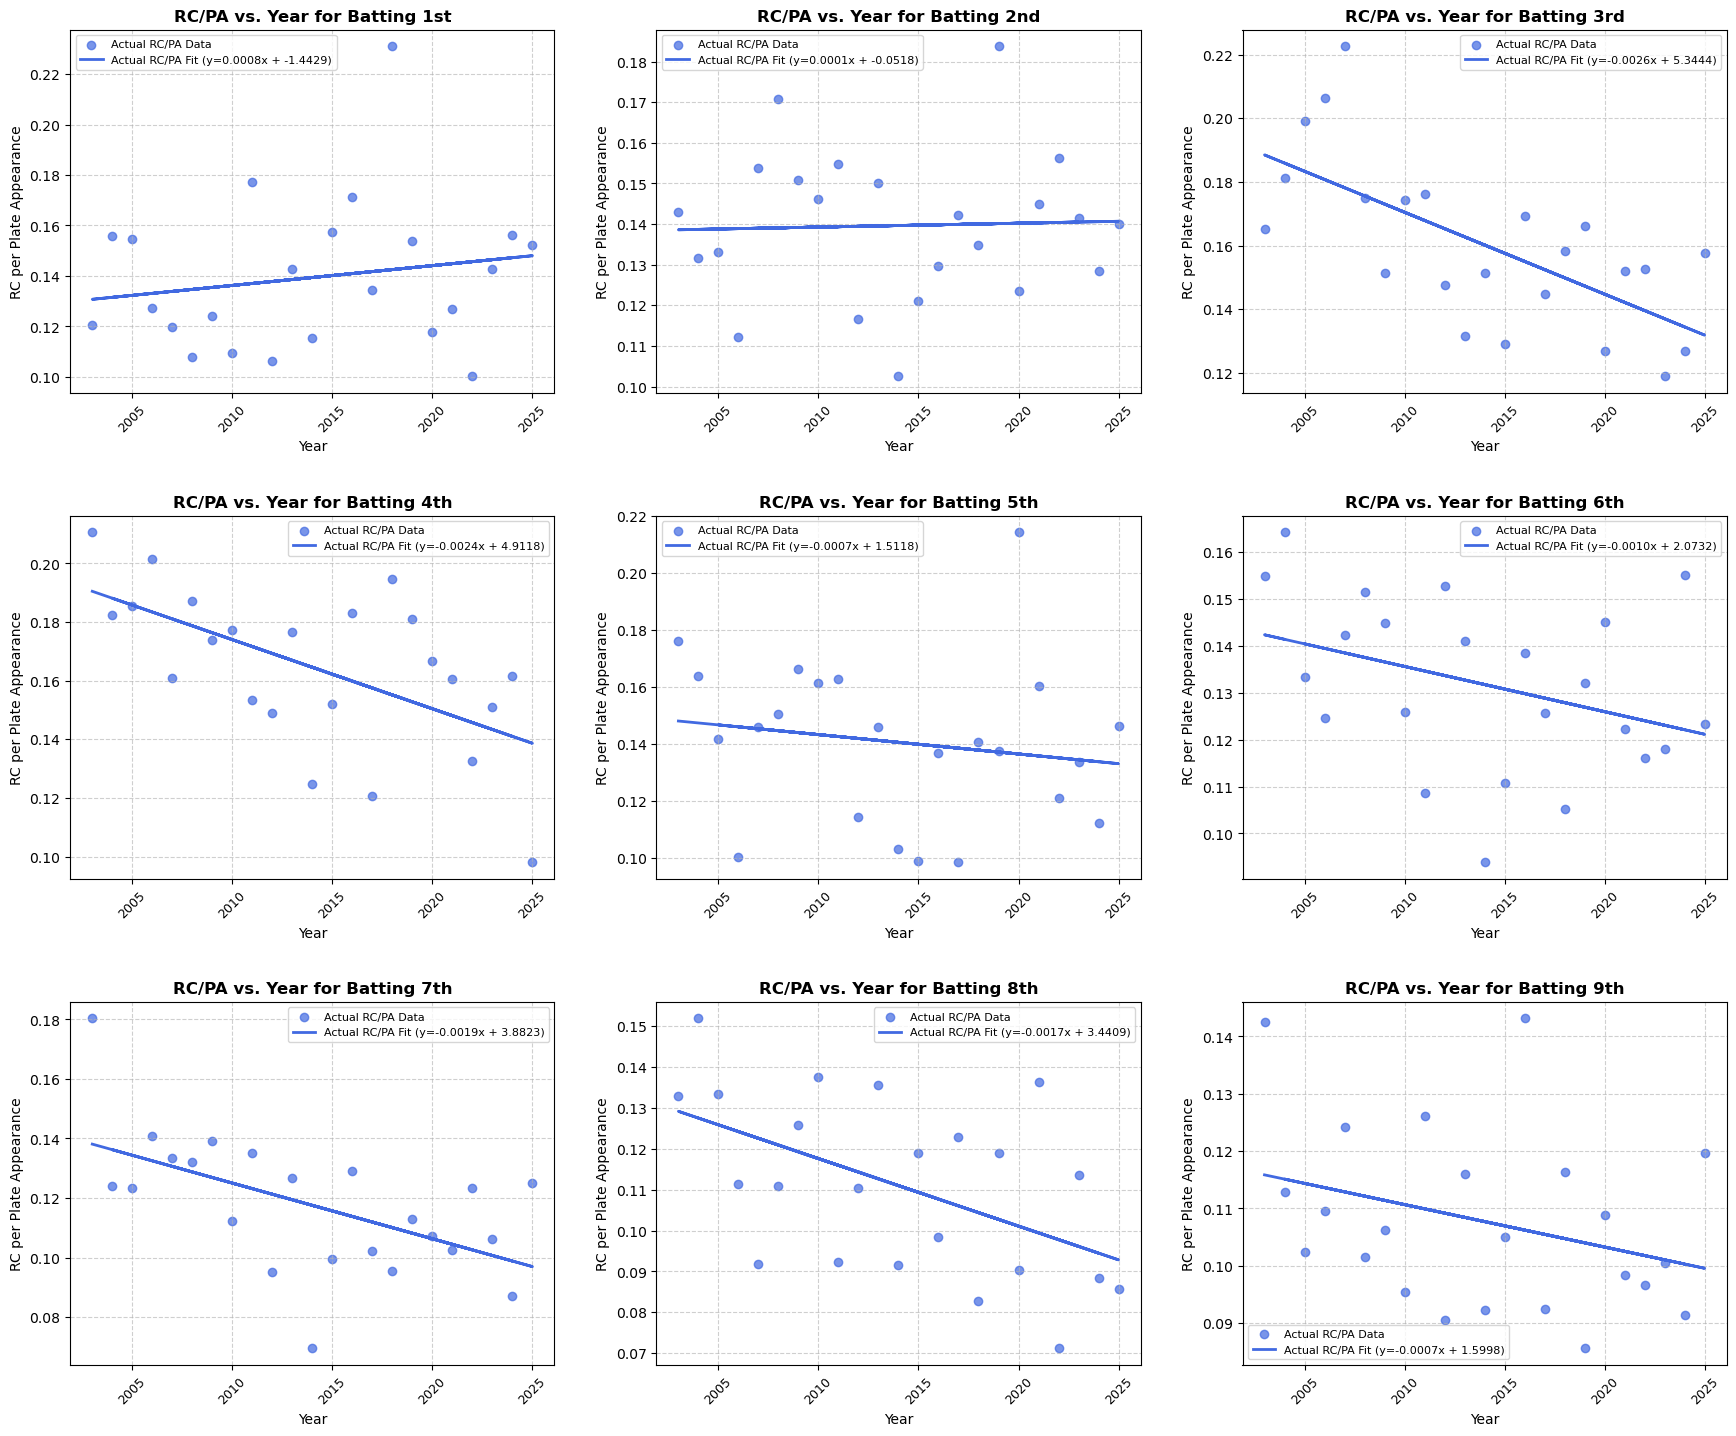

In [115]:
REDSOX_FILE_PATH = 'data/redsox_2003_2025_splits.csv'

redsox_df = process_data(REDSOX_FILE_PATH)

if redsox_df is not None and not redsox_df.empty:
    create_red_sox_plots(redsox_df)
else:
    print("Red Sox analysis could not be completed due to data processing errors.")


### Plot Analysis
The data indicates that the Red Sox have been increasing production out of the first two batting spots in the lineup, while decreasing production elsewhere. This is representative of a more general trend within baseball: give your good players more plate appearances. The linear fits also show an aggressive decrease from the third and fourth positions. I believe this to be indicative of the modern analytic movement, but are these trends just an effect of the managerial decisions of the time?

In [116]:
def _calculate_gradients(df: pd.DataFrame, all_splits: List[str]) -> Dict[str, float]:
    """Calculates the linear trendline gradient (slope) for each batting split.

    This helper function iterates through a list of batting splits, filters the
    DataFrame for each, and computes the slope of the RC_per_PA trend over
    the years using a first-degree polynomial fit.

    Args:
        df: The DataFrame containing the data for gradient calculation.
        all_splits: A list of unique 'Split' strings to analyze.

    Returns:
        A dictionary mapping each split to its calculated gradient. Returns
        np.nan for splits with insufficient data for a linear fit.
    """
    gradients = {}
    for split in all_splits:
        split_data = df[df['Split'] == split]
        if split_data.shape[0] >= 2:
            slope, _ = np.polyfit(split_data['Year'], split_data['RC_per_PA'], 1)
            gradients[split] = slope
        else:
            gradients[split] = np.nan
    return gradients

In [117]:
def create_time_split_tables(df: pd.DataFrame, year_ranges: List[Tuple[int, int]]) -> None:
    """Calculates and prints raw and scaled trendline gradients for time periods.

    This function analyzes performance trends within specified year ranges 
    (e.g., managerial eras) by calculating the gradient of the RC_per_PA. It
    outputs two tables: one with the raw gradients and another with gradients
    scaled for improved readability.

    Args:
        df: The processed DataFrame containing batting data.
        year_ranges: A list of (start_year, end_year) tuples defining the
                     analysis periods.
    """
    GRADIENT_SCALE_FACTOR = 10000
    all_splits = sorted(df['Split'].unique())
    summary_data = {}

    for start_year, end_year in year_ranges:
        period_df = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]
        period_name = f'Gradient ({start_year}-{end_year})'
        summary_data[period_name] = _calculate_gradients(period_df, all_splits)

    gradient_df = pd.DataFrame(summary_data, index=all_splits)
    gradient_df.index.name = 'Batting Split'

    scaled_df = gradient_df * GRADIENT_SCALE_FACTOR
    scaled_df.columns = [f'Scaled {col}' for col in gradient_df.columns]

    print("\n--- Summary of Gradients ---\n")
    print(gradient_df.to_string(float_format="{:+.6f}".format))
    print("\n" + ("-" * 45) + "\n")
    print(f"--- Scaled Gradients (Gradient * {GRADIENT_SCALE_FACTOR}) ---\n")
    print(scaled_df.to_string(float_format="{:+.2f}".format))

In [118]:
# Notable Boston Skippers: Terry Francona, John Farrell, Alex Cora
MANAGERIAL_PERIODS = [(2004, 2011), (2013, 2017), (2018, 2025)]

if redsox_df is not None and not redsox_df.empty:
    create_time_split_tables(redsox_df, MANAGERIAL_PERIODS)
else:
    print("Red Sox analysis could not be completed due to data processing errors.")


--- Summary of Gradients ---

               Gradient (2004-2011)  Gradient (2013-2017)  Gradient (2018-2025)
Batting Split                                                                  
Batting 1st               -0.001132             +0.003881             -0.005826
Batting 2nd               +0.004281             +0.001157             -0.002083
Batting 3rd               -0.004438             +0.004411             -0.002650
Batting 4th               -0.003569             -0.005368             -0.010096
Batting 5th               +0.003497             -0.006128             -0.004396
Batting 6th               -0.004243             +0.001397             +0.001853
Batting 7th               +0.000205             +0.001047             +0.001156
Batting 8th               -0.003976             -0.001847             -0.001533
Batting 9th               +0.000317             +0.000375             +0.000310

---------------------------------------------

--- Scaled Gradients (Gradient * 10000) -

### Table Analysis
The scaled gradients help with the readability of the trends. There is a large decrease in production from the fourth batting position across all three time splits and the third spot in two of the three managerial splits. It is however important to recognize that this is a very small sample size. These numbers are highly influenced by the state of the Boston roster and other extraneous factors. What do the league-wide trends look like during these timeframes?

In [119]:
def create_league_wide_plots(df: pd.DataFrame) -> None:
    """Generates a 2x2 grid comparing league-wide and BOS RC/PA trends.

    This function creates subplots for the top batting splits to visually 
    compare the performance trends of the entire league against the 
    Boston Red Sox (BOS).

    Args:
        df: The processed DataFrame containing league-wide batting data.
    """
    TEAM_ABBREVIATION = 'BOS'
    unique_splits = sorted(df['Split'].unique())
    
    if not unique_splits:
        print("No data available to plot.")
        return

    nrows, ncols = 2, 2
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 15))
    axes = axes.flatten()
    
    num_to_plot = min(len(unique_splits), nrows * ncols)

    for i, split in enumerate(unique_splits[:num_to_plot]):
        ax = axes[i]
        split_data_all = df[df['Split'] == split]
        split_data_bos = split_data_all[split_data_all['Team'] == TEAM_ABBREVIATION]

        if split_data_all.shape[0] < 2:
            ax.set_title(f"'{split}'\n(Insufficient data)")
            ax.axis('off')
            continue

        _plot_subplot(ax, split_data_all, color='royalblue', label_prefix='All Teams')
        _plot_subplot(ax, split_data_bos, color='red', label_prefix=TEAM_ABBREVIATION)

        ax.set_title(f"RC/PA vs. Year for {split}", fontsize=14, weight='bold')
        ax.set_xlabel("Year", fontsize=12)
        ax.set_ylabel("RC per Plate Appearance", fontsize=12)
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

    for i in range(num_to_plot, len(axes)):
        axes[i].axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()

In [120]:
def create_comparative_tables(df: pd.DataFrame) -> None:
    """Calculates and displays overall league-wide and BOS-specific gradients.

    This function provides a comparative summary of performance trends over
    the entire dataset, calculating and printing the gradients for both the
    league average and the Boston Red Sox.

    Args:
        df: The processed DataFrame containing league-wide batting data.
    """
    TEAM_ABBREVIATION = 'BOS'
    GRADIENT_SCALE_FACTOR = 10000
    all_splits = sorted(df['Split'].unique())

    league_gradients = _calculate_gradients(df, all_splits)
    bos_gradients = _calculate_gradients(df[df['Team'] == TEAM_ABBREVIATION], all_splits)
    
    summary_df = pd.DataFrame({
        'League Gradient': pd.Series(league_gradients),
        'BOS Gradient': pd.Series(bos_gradients)
    })
    summary_df['League Scaled Gradient'] = summary_df['League Gradient'] * GRADIENT_SCALE_FACTOR
    summary_df['BOS Scaled Gradient'] = summary_df['BOS Gradient'] * GRADIENT_SCALE_FACTOR
    summary_df.index.name = 'Batting Split'

    print("\n--- League-Wide and BOS Trendline Gradients ---\n")
    print(summary_df.to_string(float_format="{:+.4f}".format))

In [121]:
def create_delta_tables(df: pd.DataFrame, year_ranges: List[Tuple[int, int]]) -> None:
    """Calculates and prints the percentage difference between BOS and league trend gradients.

    This function computes the Delta+ metric for specified time periods, which is the
    percentage difference of the Boston Red Sox's trend gradient relative to the
    league's trend gradient ([(BOS / League) - 1] %). The output also includes
    the sign (+ or -) of the league-wide gradient in parentheses for context.

    Args:
        df: The processed DataFrame with league-wide data.
        year_ranges: A list of (start_year, end_year) tuples defining the
                     analysis periods.
    """
    TEAM_ABBREVIATION = 'BOS'
    all_splits = sorted(df['Split'].unique())
    delta_plus_summary = {}

    for start_year, end_year in year_ranges:
        period_name = f'({start_year}-{end_year})'
        period_df = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]

        league_gradients = _calculate_gradients(period_df, all_splits)
        bos_gradients = _calculate_gradients(
            period_df[period_df['Team'] == TEAM_ABBREVIATION], all_splits
        )

        period_delta_pluses = {}

        for split in all_splits:
            bos_grad = bos_gradients.get(split, np.nan)
            lg_grad = league_gradients.get(split, np.nan)

            if lg_grad is not None and not np.isnan(lg_grad) and lg_grad != 0:
                delta_plus_value = ((bos_grad / lg_grad) - 1) * 100
                lg_sign = '+' if lg_grad > 0 else '-'
                value_to_store = f"{delta_plus_value:+.2f} ({lg_sign})"
            else:
                value_to_store = f"{np.inf:+.2f} ( )"

            period_delta_pluses[split] = value_to_store

        delta_plus_summary[f'Delta+ {period_name}'] = period_delta_pluses

    delta_plus_df = pd.DataFrame(delta_plus_summary, index=all_splits)
    delta_plus_df.index.name = 'Batting Split'

    print("\n--- Gradient Percentage Difference ([(BOS / League) - 1] %) ---\n")
    print(delta_plus_df.to_string())

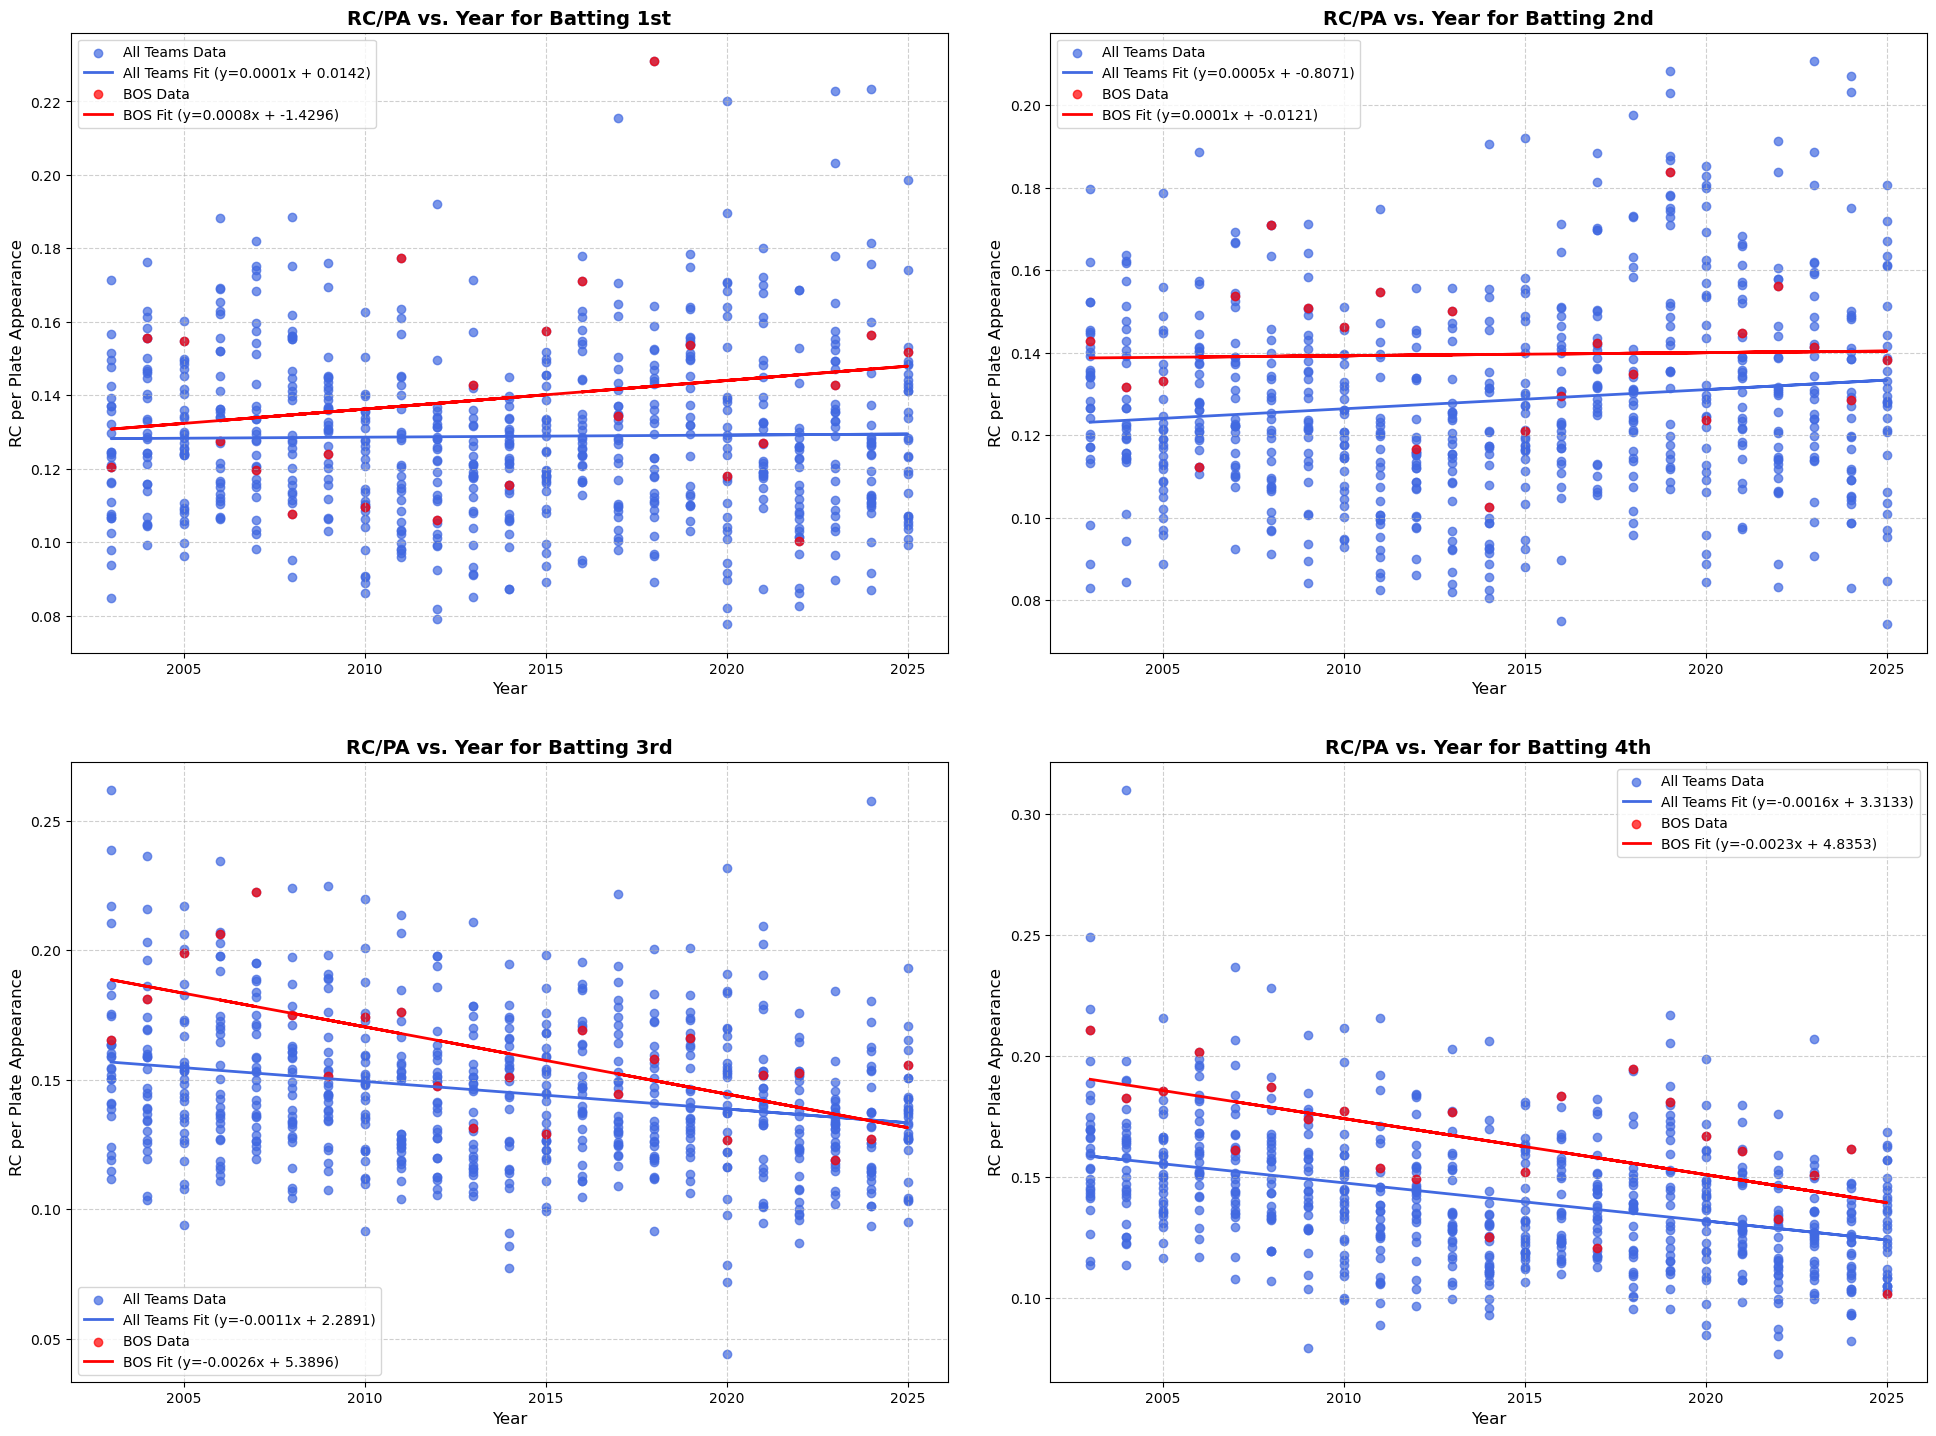


--- Summary of Gradients ---

               Gradient (2004-2011)  Gradient (2013-2017)  Gradient (2018-2025)
Batting Split                                                                  
Batting 1st               -0.001421             +0.003567             -0.000480
Batting 2nd               -0.001424             +0.005256             -0.001342
Batting 3rd               -0.001505             +0.002216             -0.001530
Batting 4th               -0.003144             +0.001779             -0.002375

---------------------------------------------

--- Scaled Gradients (Gradient * 10000) ---

               Scaled Gradient (2004-2011)  Scaled Gradient (2013-2017)  Scaled Gradient (2018-2025)
Batting Split                                                                                       
Batting 1st                         -14.21                       +35.67                        -4.80
Batting 2nd                         -14.24                       +52.56                      

In [122]:
LEAGUE_FILE_PATHS = [
    "data/league-wide/bat_1st_2003_2005_splits.csv", "data/league-wide/bat_1st_2006_2025_splits.csv", "data/league-wide/bat_1st_2016_2025_splits.csv",
    "data/league-wide/bat_2nd_2003_2005_splits.csv", "data/league-wide/bat_2nd_2006_2015_splits.csv", "data/league-wide/bat_2nd_2016_2025_splits.csv",
    "data/league-wide/bat_3rd_2003_2005_splits.csv", "data/league-wide/bat_3rd_2006_2015_splits.csv", "data/league-wide/bat_3rd_2016_2025_splits.csv",
    "data/league-wide/bat_4th_2003_2005_splits.csv", "data/league-wide/bat_4th_2006_2015_splits.csv", "data/league-wide/bat_4th_2016_2025_splits.csv"
]

league_dataframes = [process_data(file) for file in LEAGUE_FILE_PATHS]
league_dataframes = [df for df in league_dataframes if df is not None]

if league_dataframes:
    combined_league_df = pd.concat(league_dataframes, ignore_index=True)
    create_league_wide_plots(combined_league_df)
    create_time_split_tables(combined_league_df, MANAGERIAL_PERIODS)
    print("\n" + ("-" * 45) + "\n")
    create_comparative_tables(combined_league_df)
    print("\n" + ("-" * 45) + "\n")
    create_delta_tables(combined_league_df, MANAGERIAL_PERIODS)
else:
    print("League-wide analysis could not be completed due to data processing errors.")

## Hitting Cleanup
### Comparative Analysis
The Boston Red Sox are known for being a more sabermetrics focused franchise, which is supported by the overall gradient trend. "Plus" statistics are common in modern baseball analytics. While commonly used for comparing players to the league average, I found it intuitive in this scenario to compare the Red Sox to the rest of the league over the different managerial periods. 

It is however important to note that these "plus" and "minus" (e.g. FIP-) statistics are commonly derived from positive-only values. Negative values in this context indicate that the Red Sox trend moved in the opposite direction of the league trend, so I've included the league-wide sign next to these values for context.

Again, these numbers are highly influenced by external factors. A common obstacle within baseball analytics is overcoming noisy data generated from small samples. The next step is to dive deeper to better understand the league environment and why these values make sense.

In [ ]:
def create_batting_environment_plots(df: pd.DataFrame, year_ranges: List[Tuple[int, int]]) -> None:
    
